In [46]:
using WriterVerifier

In [ ]:
using Images, FileIO, Random, Plots, Statistics
Random.seed!(42);

image_folder = "../data/words"
writers = load_images(image_folder; max_per_writer=100, max_writers=100);

In [48]:
println("Dataset statistics:")
println("Total writers: $(length(writers))")
println("Total images: $(sum(length(images) for images in values(writers)))")

image_counts = [length(images) for images in values(writers)]
println("\nImages per writer:")

Dataset statistics:
Total writers: 76
Total images: 7560

Images per writer:


In [49]:
writer_names = collect(keys(writers))
selected_writers = writer_names[1:min(5, length(writer_names))]

println("Sample writers:")
for writer in selected_writers
    println("$writer: $(length(writers[writer])) images")
    println("  First image: $(basename(writers[writer][1]))")
    println("  Last image: $(basename(writers[writer][end]))")
end

Sample writers:
f01: 100 images
  First image: f01-053-00-00.png
  Last image: f01-058-03-05.png
d01: 100 images
  First image: d01-016-00-00.png
  Last image: d01-019-03-05.png
g05: 100 images
  First image: g05-087-00-00.png
  Last image: g05-094-04-05.png
e07: 100 images
  First image: e07-000-00-00.png
  Last image: e07-003-04-05.png
e02: 100 images
  First image: e02-000-00-00.png
  Last image: e02-014-03-05.png


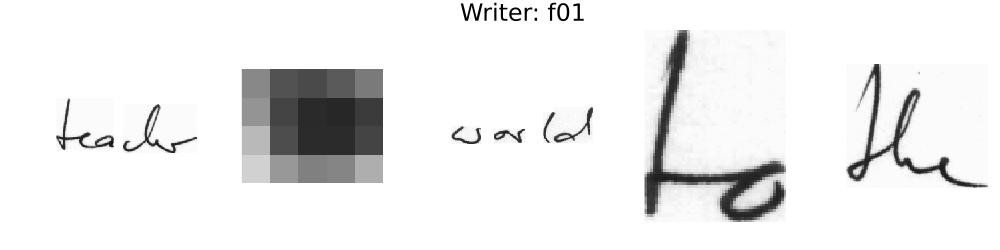

In [50]:
function display_writer_samples(writer_id, n_samples=5)
    if !haskey(writers, writer_id)
        println("Writer $writer_id not found")
        return
    end
    
    images = writers[writer_id]
    n_show = min(n_samples, length(images))
    sample_indices = randperm(length(images))[1:n_show]
    
    plots = []
    for i in sample_indices
        img_path = images[i]
        img = load(img_path)
        
        p = plot(Gray.(img), 
                axis=false,
                showaxis=false,
                grid=false)
        push!(plots, p)
    end
    
    plot(plots..., layout=(1, n_show), size=(200*n_show, 250),
         plot_title="Writer: $writer_id")
end

display_writer_samples(first(writer_names))

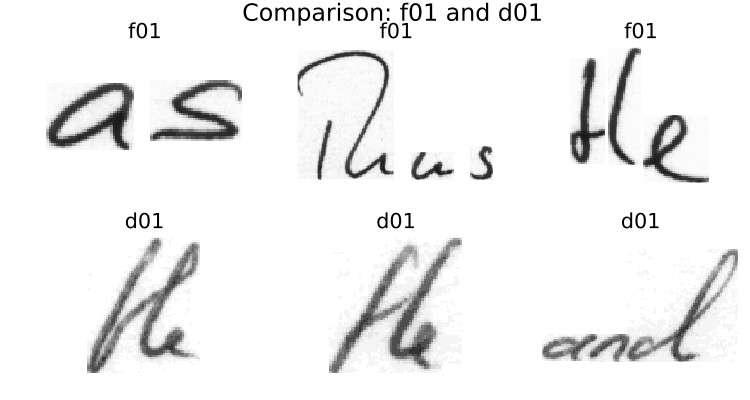

In [51]:
function compare_writers(writer1, writer2, n_samples=3)
    plots = []
    
    for (i, writer) in enumerate([writer1, writer2])
        if !haskey(writers, writer)
            println("Writer $writer not found")
            continue
        end
        
        images = writers[writer]
        sample_indices = randperm(length(images))[1:min(n_samples, length(images))]
        
        for j in sample_indices
            img_path = images[j]
            img = load(img_path)
            
            p = plot(Gray.(img),
                    title="$writer",
                    axis=false,
                    showaxis=false,
                    grid=false)
            push!(plots, p)
        end
    end
    
    plot(plots..., layout=(2, n_samples), size=(250*n_samples, 400),
         plot_title="Comparison: $writer1 and $writer2")
end

if length(writer_names) >= 2
    compare_writers(writer_names[1], writer_names[2])
end

Testing image processing on: f01-053-00-00.png
Original size: (90, 136)
Processed size: (64, 128, 1)
Processed type: Float32
Processed range: [-0.773, 0.969]


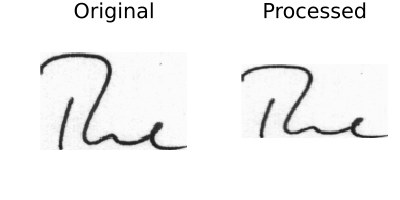

In [52]:
test_image_path = writers[first(writer_names)][1]
println("Testing image processing on: $(basename(test_image_path))")

original_img = load(test_image_path)
processed_img = process_image(test_image_path)

println("Original size: $(size(original_img))")
println("Processed size: $(size(processed_img))")
println("Processed type: $(eltype(processed_img))")
println("Processed range: [$(round(minimum(processed_img), digits=3)), $(round(maximum(processed_img), digits=3))]")

p1 = plot(Gray.(original_img), title="Original", axis=false, showaxis=false, grid=false)
p2 = plot(Gray.((processed_img[:,:,1] .+ 1) ./ 2), title="Processed", axis=false, showaxis=false, grid=false)
plot(p1, p2, layout=(1,2), size=(400, 200))